## Found how to get partial_decompress=True from zarr_python library code, file "build/lib/zarr/tests/test_core.py" test function test_read_nitems_less_than_blocksize_from_multiple_chunks in line 2683

In [1]:
import zarr # Check version
zarr.__version__

'2.13.2'

Zarr Sharding pull request should show '0.0.0'

If it says e.g. 2.13.2, then you're running on the "proper" published version (without Sharding support as of 28-Sept-2022)

<font color="orange">partial_decompress works on current version 2.13, no need for Sharding</font>

### 1. I wanna test partial_decompression by accessing a random index

In [108]:
import numpy as np


numpy_arr = np.empty((65536, 16384), dtype=np.int32) # ~3GB
original_shape = numpy_arr.shape

# 50k x 150k int32 is limit of M1 Pro 32GB
for i in range(numpy_arr.shape[0]):
#     numpy_arr[i][:] = list(range(original_shape[1]*i, original_shape[1]*(i+1)))
    numpy_arr[i][:] = np.random.randint(low=0, high=original_shape[0], size=original_shape[1])

In [109]:
print("Memory used: ", numpy_arr.nbytes / 1024 / 1024 / 1024, " GB")

Memory used:  4.0  GB


In [110]:
numpy_arr[0][0:10]

array([ 7298, 28848, 13914, 34926, 35384, 34286, 17281,  7320, 62590,
       59453], dtype=int32)

In [114]:
fsstore = zarr.storage.FSStore('./fsstore256MBChunk')
zarr_index_list = zarr.array(numpy_arr, store=fsstore, chunks=chunk_shape)
zarr.save(fsstore, numpy_arr)

### Following code in zarr test_core.py:2653

In [7]:
# All these extra parameters are irrelevant to _partial_decompress being enabled. Path is enough
# fsstore = zarr.storage.FSStore('./fsstore', key_separator="/", auto_mkdir=True, mode='w', normalize_keys=False)

fsstore = zarr.storage.FSStore('./fsstore4MB')

In [8]:
# chunk_size=(4096,4096)

zarr_index_list = zarr.array(numpy_arr, store=fsstore)#, chunk_store = fsstore_chunk, partial_decompress=True, chunks=chunk_size, dtype='i4')# compressor=weak_compressor, 

In [9]:
zarr_index_list.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [10]:
print("_partial_decompress: ", zarr_index_list._partial_decompress)

_partial_decompress:  False


<font color="orange">As we can see, partial_decompress is False. Don't panic!</font>

In [11]:
# Flush to disk
zarr.save(fsstore, numpy_arr)

In [12]:
# Load from disk

# read_only doesn't affect partial_decompress eligibility
load_partial_decomp = zarr.Array(fsstore, read_only=True, partial_decompress=True)

In [13]:
load_partial_decomp._partial_decompress

True

#### <font color="orange">Solved! Partial_decompress=True</font>

In [14]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [15]:
# del numpy_arr # Don't need this anymore - save 3GB

Sometimes chunks not even initialized? Sometimes 2 arrays are written to disk (i.e. a group). Not sure why

In [16]:
load_partial_decomp[0, 100:105]

array([28904, 43120, 25319, 37625, 47725], dtype=int32)

In [17]:
load_disk_normally = zarr.open(fsstore) # , partial_decompress=True) -- This won't work !!

In [18]:
load_disk_normally._partial_decompress

False

In [19]:
load_disk_normally[0, 100:105]

array([28904, 43120, 25319, 37625, 47725], dtype=int32)

In [20]:
# Do the two match?
(load_partial_decomp[0, 100:105] == load_disk_normally[0, 100:105]).all()

True

### Let's test random access of chunks by index

In [22]:
chunk_shape = (2048, 512)

In [27]:
rand_indices_list = np.random.randint(low=0, high=chunk_shape[0], size=50)

In [28]:
%%timeit
# Read randomly from first chunk, Using partial decompression

for index in rand_indices_list:
    load_partial_decomp[0, index]

39.7 ms ± 4.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for index in rand_indices_list:
    load_disk_normally[0, index]

58.6 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### <font color="orange">Let's access the chunks using 2D accesses now</font>

In [30]:
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [31]:
rand_indices_tuples

(array([ 186, 1502,   61,  632,  467,  552,  368,  319,  120,  143, 1928,
         408, 1720, 1502,  410, 1768,  565,  948, 1486,  425,  410, 1775,
        1086, 1872,  607,  668, 1010,  513,  760, 1706, 1750,  511,  225,
        1192,  541,  440, 1609, 1014, 1511, 1754, 1532, 1560, 1793, 1120,
        1495,   39, 2027, 2015, 1902,  320]),
 array([112, 440,  34, 212, 159, 243, 334, 433, 346, 209, 277, 122,  66,
         91, 448,   0, 183,  46, 196, 446, 355, 211, 407,  98, 420, 308,
        455, 180, 386, 264, 229, 138, 453, 254, 468, 465, 237, 488, 499,
        230, 317, 309,  75, 505,  70, 437,   8, 331, 409, 329]))

In [32]:
rand_indices_tuples[0][1]

1502

TODO set range(50) programmatically

In [33]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

37.8 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

56.2 ms ± 959 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## <font color="orange"> New experiment: access one point per chunk in the whole array</font>

In [69]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [75]:
32**2

1024

In [76]:
from itertools import product

In [81]:
# rand_indices_whole_array = []

xes = []
ys = []

for i in range(32): # there's 32x32 chunks. TODO get programmatically
    # 2d point access - let's not just access first row of chunk
    
    # Random point across all chunks
#     x = np.random.randint(low=i*chunk_shape[0]+5, high=(i+1)*chunk_shape[0] + 5)
#     y = np.random.randint(low=i*chunk_shape[1]+5, high=(i+1)*chunk_shape[1]+5)
    
    xes.append(i*chunk_shape[0]+50)
    ys.append(i*chunk_shape[1]+50)
    
    # "Same" point across all chunks

#     rand_indices_whole_array.append((x,y))
    
    # 1D access - makes indexing complicated
#     rand_indices_whole_array.append(np.random.randint(low=i*chunk_shape[0], high=(i+1)*chunk_shape[1]))

rand_indices_whole_array = list(product(xes, ys))
rand_indices_whole_array

[(50, 50),
 (50, 562),
 (50, 1074),
 (50, 1586),
 (50, 2098),
 (50, 2610),
 (50, 3122),
 (50, 3634),
 (50, 4146),
 (50, 4658),
 (50, 5170),
 (50, 5682),
 (50, 6194),
 (50, 6706),
 (50, 7218),
 (50, 7730),
 (50, 8242),
 (50, 8754),
 (50, 9266),
 (50, 9778),
 (50, 10290),
 (50, 10802),
 (50, 11314),
 (50, 11826),
 (50, 12338),
 (50, 12850),
 (50, 13362),
 (50, 13874),
 (50, 14386),
 (50, 14898),
 (50, 15410),
 (50, 15922),
 (2098, 50),
 (2098, 562),
 (2098, 1074),
 (2098, 1586),
 (2098, 2098),
 (2098, 2610),
 (2098, 3122),
 (2098, 3634),
 (2098, 4146),
 (2098, 4658),
 (2098, 5170),
 (2098, 5682),
 (2098, 6194),
 (2098, 6706),
 (2098, 7218),
 (2098, 7730),
 (2098, 8242),
 (2098, 8754),
 (2098, 9266),
 (2098, 9778),
 (2098, 10290),
 (2098, 10802),
 (2098, 11314),
 (2098, 11826),
 (2098, 12338),
 (2098, 12850),
 (2098, 13362),
 (2098, 13874),
 (2098, 14386),
 (2098, 14898),
 (2098, 15410),
 (2098, 15922),
 (4146, 50),
 (4146, 562),
 (4146, 1074),
 (4146, 1586),
 (4146, 2098),
 (4146, 2610),

In [82]:
len(rand_indices_whole_array) # Should equal n_chunks

1024

In [83]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk

for tup in rand_indices_whole_array:
    load_partial_decomp[tup[0], tup[1]]

898 ms ± 69.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk
# TODO Don't know if my indexing is correct!!

for tup in rand_indices_whole_array:
    load_disk_normally[tup[0], tup[1]]

1.34 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
print("Speedup: ", 1.34 / .9)

Speedup:  1.488888888888889


### <font color="orange">Let's test advanced mask indexing</font>

In [86]:
# Create a 0-1 boolean mask with size same as Whole array
#    Don't know how to do just 1 chunk masking
bool_mask = np.random.randint(low=0, high=2, size=original_shape, dtype=bool)
bool_mask

array([[ True,  True, False, ...,  True,  True, False],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False, False, ...,  True,  True,  True],
       ...,
       [False,  True, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True, False,  True]])

In [87]:
%%timeit
# Partial decompress

# _ to prevent printing
_ = load_partial_decomp.get_mask_selection(bool_mask)

53.1 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit
# NO Partial decompress

# _ to prevent printing
_ = load_disk_normally.get_mask_selection(bool_mask)

56.3 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## <font color="red">Trying 16MB chunks. partial_decompress Benefits should be bigger for bigger chunks</font>

In [93]:
fsstore_8mb = zarr.storage.FSStore("./fsstore16MBChunk")

In [100]:
chunk_shape = (4096,1024) #16MB

In [94]:
zarr_index_list_16MB_Chunk = zarr.array(numpy_arr, store=fsstore_8mb, chunks = chunk_size_8mb)

In [95]:
zarr.save(fsstore_16mb, zarr_index_list_8MB_Chunk)

In [96]:
load_partial_decomp_16mb = zarr.Array(fsstore_16mb, partial_decompress=True)

In [97]:
load_disk_normally_16mb = zarr.Array(fsstore_16mb, partial_decompress=False)

In [101]:
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [102]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp_16mb[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

31.8 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally_16mb[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

112 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## <font color="red">64 MB chunks</font>

In [105]:
fsstore = zarr.storage.FSStore("./fsstore64MBChunk")
chunk_shape = (8192,2048)
zarr_index_list = zarr.array(numpy_arr, store=fsstore, chunks = chunk_shape)
zarr.save(fsstore, zarr_index_list)
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [106]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

31.5 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

425 ms ± 8.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## <font color="red">256MB Chunk</font>

In [110]:
fsstore = zarr.storage.FSStore("./fsstore256MBChunk")
chunk_shape = (16384,4096)
zarr_index_list = zarr.array(numpy_arr, store=fsstore, chunks = chunk_shape)
zarr.save(fsstore, zarr_index_list)
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [2]:
fsstore = zarr.storage.FSStore("./fsstore256MBChunk")

In [7]:
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)

In [9]:
load_partial_decomp._partial_decompress

True

In [111]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

36.7 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

1.62 s ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## <font color="red">1GB Chunk - write then read</font>

In [ ]:
fsstore = zarr.storage.FSStore("./fsstore1GBChunk")
chunk_shape = (32768,8192)
zarr_index_list = zarr.array(numpy_arr, store=fsstore, chunks = chunk_shape)
zarr.save(fsstore, zarr_index_list)
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [ ]:
%%timeit
# Read randomly from first chunk

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

In [116]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

6.82 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
xes = []
ys = []

for i in range(2): # N chunks
    xes.append(i*chunk_shape[0]+50)
    ys.append(i*chunk_shape[1]+50)
    

rand_indices_whole_array = list(product(xes, ys))
rand_indices_whole_array

[(50, 50), (50, 8242), (32818, 50), (32818, 8242)]

In [118]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk

for tup in rand_indices_whole_array:
    load_partial_decomp[tup[0], tup[1]]

2.46 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [119]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk

for tup in rand_indices_whole_array:
    load_disk_normally[tup[0], tup[1]]

532 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### <font color="red">1. Run for longer than 50, see if serializing only once the big chunk, or every time you index it


2. Figure out decompression unit size. Experiment: Access ranges: 1K, 4K, 16K, 64K - 1M - 16M
</font>

3. Can we change compression size? & tradeoffs w/ different sizes


3. Crossover betw. one at a time IO and loading whole chunks & indexing points. See how many points you need to index for partial_decompress to be slower


4. Mask with sparse, p=0.05

# New Experiments - just read existing data (don't create new FSStores)

In [117]:
import numpy as np
import zarr

# Define data location
fsstore = zarr.storage.FSStore("./fsstore256MBChunk")
# Load data - partial_decompress and full decompress
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)

In [118]:
load_partial_decomp._partial_decompress

True

In [119]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


<font color="orange">Need the above to determine chunk shape. Don't know how to get that programmatically yet</font>

In [18]:
chunk_shape = (16384,4096)

### Experiment 1: run for longer access (>50)

In [53]:
# Create Random indices to test access speed

index_lengths = range(50,2000,50) # [50, 100, 150 ... 2000]

indices_various_len = []
for ind_len in index_lengths:
    indices_various_len.append(np.array((np.random.randint(low=0, high=chunk_shape[0], size=ind_len), np.random.randint(low=0, high=chunk_shape[1], size=ind_len))).T)

In [301]:
indices_various_len

[array([[ 4350,   707],
        [ 6420,  2231],
        [ 6202,   867],
        [  805,   645],
        [ 9328,  1212],
        [ 9313,  3034],
        [ 9402,  1465],
        [ 1461,  1608],
        [ 8984,  4092],
        [ 6441,  2719],
        [13419,   315],
        [ 8848,  2826],
        [  591,  2885],
        [15268,  3607],
        [ 6434,    31],
        [15708,   686],
        [ 7005,  1725],
        [13976,   342],
        [ 2763,   509],
        [15908,  1683],
        [15972,  3623],
        [13608,  2889],
        [13205,  1430],
        [ 9280,  1110],
        [14487,  2777],
        [  922,   361],
        [ 5829,  3413],
        [ 5950,  3552],
        [ 4063,  4065],
        [ 4180,   324],
        [15017,  2497],
        [ 7035,  1320],
        [14372,  1172],
        [ 2430,   470],
        [13214,  3788],
        [13340,  2467],
        [12511,  1584],
        [16350,  3010],
        [ 7587,  1893],
        [ 6178,  3837],
        [ 2902,    26],
        [15478, 

In [60]:
def access_random_indices_chunk(i, loaded_array):
    # Random access of various points in 1 Zarr array chunk
    # This shows the cutoff of how many points-per-chunk makes using
    # partial_decompress=True advantagous
    # Moved to separate function to make %timeit easy
    #
    # Args:
    #    i - how many random accesses to do per chunk (chosen from indices_various_len)
    #    loaded_array - zarr array to access elements from
    test_indices = indices_various_len[i] # For readability
    index_length = indices_various_len[i].shape[0]
    
    for j in range(index_length):
        loaded_array[test_indices[j][0], test_indices[j][1]]

#### partial_decompress

In [71]:
partial_decomp_chunk_access = []

for i in range(len(index_lengths)):
    _ = %timeit -o access_random_indices_chunk(i, load_partial_decomp)
    partial_decomp_chunk_access.append(_)

157 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
315 ms ± 9.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
495 ms ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
721 ms ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
903 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
945 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.09 s ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.33 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.39 s ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.63 s ± 94.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.83 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.93 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16 s ± 93.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.17 s ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.33 s ± 22.8 ms per loop (mean ± std. dev. of 7 runs

#### no partial_decompress

In [80]:
no_decomp_chunk_access = []

for i in range(len(index_lengths[:15])): # Stopped at 15/40 since it's so slow
    _ = %timeit -o access_random_indices_chunk(i, load_disk_normally)
    no_decomp_chunk_access.append(_)

1.81 s ± 46.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.48 s ± 34.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.31 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.3 s ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.08 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.2 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.9 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.8 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.1 s ± 587 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.4 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
23.7 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25.8 s ± 410 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.6 s ± 286 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.4 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop 

##### Pickle above results to file - let's not lose experiments

In [83]:
import pickle

partial_random_chunk_acc_file = open("partial_random_chunk_acc.pickle", 'wb')
normal_random_chunk_acc_file = open("normal_random_chunk_acc.pickle", "wb")

pickle.dump(partial_decomp_chunk_access, partial_random_chunk_acc_file)
pickle.dump(no_decomp_chunk_access, normal_random_chunk_acc_file)

In [84]:
partial_random_chunk_acc_file.close()
normal_random_chunk_acc_file.close()

### Experiment 2 - Stabbing queries

<font color="red"> Loading 4MB chunks. 256MB chunk leads to only 8 chunks</font>

In [156]:
import numpy as np
import zarr

# Define data location
fsstore = zarr.storage.FSStore("./fsstore4MB")
# Load data - partial_decompress and full decompress
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)

In [158]:
load_partial_decomp._partial_decompress

True

In [157]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [161]:
chunk_shape = (2048, 512)

In [187]:
from itertools import product

xes = []
ys = []

for i in range(1, 31): # there's 32x32 chunks. TODO get programmatically
    # 2d point access - let's not just access first row of chunk
    
    xes.append(i*int(chunk_shape[0]/2))
    ys.append(i*int(chunk_shape[1]/2))
    

middle_indices_all_chunks = list(product(xes, ys))
middle_indices_all_chunks

[(1024, 256),
 (1024, 512),
 (1024, 768),
 (1024, 1024),
 (1024, 1280),
 (1024, 1536),
 (1024, 1792),
 (1024, 2048),
 (1024, 2304),
 (1024, 2560),
 (1024, 2816),
 (1024, 3072),
 (1024, 3328),
 (1024, 3584),
 (1024, 3840),
 (1024, 4096),
 (1024, 4352),
 (1024, 4608),
 (1024, 4864),
 (1024, 5120),
 (1024, 5376),
 (1024, 5632),
 (1024, 5888),
 (1024, 6144),
 (1024, 6400),
 (1024, 6656),
 (1024, 6912),
 (1024, 7168),
 (1024, 7424),
 (1024, 7680),
 (2048, 256),
 (2048, 512),
 (2048, 768),
 (2048, 1024),
 (2048, 1280),
 (2048, 1536),
 (2048, 1792),
 (2048, 2048),
 (2048, 2304),
 (2048, 2560),
 (2048, 2816),
 (2048, 3072),
 (2048, 3328),
 (2048, 3584),
 (2048, 3840),
 (2048, 4096),
 (2048, 4352),
 (2048, 4608),
 (2048, 4864),
 (2048, 5120),
 (2048, 5376),
 (2048, 5632),
 (2048, 5888),
 (2048, 6144),
 (2048, 6400),
 (2048, 6656),
 (2048, 6912),
 (2048, 7168),
 (2048, 7424),
 (2048, 7680),
 (3072, 256),
 (3072, 512),
 (3072, 768),
 (3072, 1024),
 (3072, 1280),
 (3072, 1536),
 (3072, 1792),
 (30

In [218]:
x_dirs = [2**i for i in range(0, 11)] # [-128 : 128] type-access (i.e. either side of center), so multi. by 2
y_dirs = [int(x / 4) for x in x_dirs]

# Fix y to match x as much as possible. Leave top y-s at 2048 (i.e. whole chunk vertical length / 2)

y_dirs[0] = 256
y_dirs[1] = 256

# x_dirs.append(0)
# y_dirs.append(0)

x_dirs.sort()
y_dirs.sort()
print("x_dirs: ", x_dirs)
print("new y_dirs: ", y_dirs)

x_dirs:  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
new y_dirs:  [1, 2, 4, 8, 16, 32, 64, 128, 256, 256, 256]


In [220]:
def stabbing_access(x_stab_size, y_stab_size, target_array):
    for tup in middle_indices_all_chunks:
#         print([tup[0]-x_stab_size, tup[0]+x_stab_size])
        target_array[tup[0]-x_stab_size:tup[0]+x_stab_size, tup[1]-y_stab_size:tup[1]+y_stab_size]

In [221]:
%%timeit
# Stab size of 1 - single point. Complicated indexing prevents me from putting it above

for tup in middle_indices_all_chunks:
    load_partial_decomp[tup[0], tup[1]]

1.13 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [222]:
stabbing_partial = [] # only 3 runs

for i in range(len(x_dirs)):
    _ = %timeit -r 3 -o stabbing_access(x_dirs[i], y_dirs[i], load_partial_decomp)
    stabbing_partial.append(_)

3.06 s ± 139 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4.15 s ± 189 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6.53 s ± 236 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
11.1 s ± 197 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
19.7 s ± 240 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
37.6 s ± 340 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1min 13s ± 79 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2min 25s ± 927 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3min 14s ± 762 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6min 24s ± 1.68 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
12min 35s ± 782 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [224]:
%%timeit
# Stab size of 1 - single point. Complicated indexing prevents me from putting it above

for tup in middle_indices_all_chunks:
    load_disk_normally[tup[0], tup[1]]

1.68 s ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [226]:
stabbing_normal = [] # only 3 runs

for i in range(len(x_dirs)):
    _ = %timeit -r 3 -o stabbing_access(x_dirs[i], y_dirs[i], load_disk_normally)
    stabbing_normal.append(_)

2.96 s ± 4.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.15 s ± 278 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.96 s ± 13.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.97 s ± 20.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.98 s ± 24.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.29 s ± 401 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.2 s ± 19.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.23 s ± 18.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.28 s ± 13.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.61 s ± 19.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.7 s ± 11.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [234]:
s_part2 = stabbing_partial.copy()

In [235]:
s_part2

[<TimeitResult : 3.06 s ± 139 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 4.15 s ± 189 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 6.53 s ± 236 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 11.1 s ± 197 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 19.7 s ± 240 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 37.6 s ± 340 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 1min 13s ± 79 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 2min 25s ± 927 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3min 14s ± 762 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 6min 24s ± 1.68 s per loop (mean ± std. dev. of 3 runs, 1 loop each)>]

In [240]:
# stabbing_partial = [] # only 3 runs

# for i in range(len(x_dirs)):
_ = %timeit -r 1 -o stabbing_access(1024, 256, load_partial_decomp)
stabbing_partial.append(_)

KeyboardInterrupt: 

In [236]:
len(x_dirs)

11

In [238]:
x_dirs[10]

1024

In [241]:
# Pickle

import pickle

stabbing_partial_file = open("stabbing_partial.pickle", 'wb')
stabbing_normal_file = open("stabbing_normal.pickle", "wb")

pickle.dump(stabbing_partial, stabbing_partial_file)
pickle.dump(stabbing_normal, stabbing_normal_file)

stabbing_partial_file.close()
stabbing_normal_file.close()

### Experiment 3 - Large Square In-Chunk Access

Idea: find how big the "partial" decompression piece is

In [288]:
# Load 256MB chunks afresh

import numpy as np
import zarr

# Define data location
fsstore = zarr.storage.FSStore("./fsstore256MBChunk")
# Load data - partial_decompress and full decompress
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
chunk_shape = (16384, 4096)

In [291]:
load_disk_normally[0, 0:10]

array([ 7298, 28848, 13914, 34926, 35384, 34286, 17281,  7320, 62590,
       59453], dtype=int32)

In [290]:
access_sizes = [2**i for i in range(12, 27)] # 64 KB - 256MB sequential access
access_sizes

[4096,
 8192,
 16384,
 32768,
 65536,
 131072,
 262144,
 524288,
 1048576,
 2097152,
 4194304,
 8388608,
 16777216,
 33554432,
 67108864]

In [293]:
[int(a / chunk_shape[1]) for a in access_sizes]

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [295]:
decomp_sequential_access = []

for acc_size in access_sizes:
    _ = %timeit -o load_partial_decomp[0:int(acc_size / chunk_shape[1]), 0:4096]
    decomp_sequential_access.append(_)

7.4 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.51 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.78 ms ± 531 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.51 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.1 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.1 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.7 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.1 ms ± 688 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.8 ms ± 655 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.4 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
46 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
91.7 ms ± 482 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
198 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
365 ms ± 7.78 

In [296]:
no_decomp_sequential_access = []

for acc_size in access_sizes:
    _ = %timeit -o load_disk_normally[0:int(acc_size / chunk_shape[1]), 0:4096]
    no_decomp_sequential_access.append(_)

9.17 ms ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.21 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.28 ms ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.3 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
12 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.53 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.82 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 ms ± 80.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 82.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.4 ms ± 75.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.8 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.6 ms ± 301 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
57.7 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [300]:
load_disk_normally[0:int(acc_size / chunk_shape[1]), 0:4096].shape

(16384, 4096)

In [297]:
# Pickle above

import pickle

partial_sequential_chunk_acc_file = open("partial_sequential_chunk_acc.pickle", 'wb')
normal_sequential_chunk_acc_file = open("normal_sequential_chunk_acc.pickle", "wb")

pickle.dump(decomp_sequential_access, partial_sequential_chunk_acc_file)
pickle.dump(no_decomp_sequential_access, normal_sequential_chunk_acc_file)

partial_sequential_chunk_acc_file.close()
normal_sequential_chunk_acc_file.close()

### Experiment 1 Plotting - In-chunk Random access

In [246]:
exp1_partial_means = [x.average for x in partial_decomp_chunk_access]
exp1_partial_stds = [x.stdev for x in partial_decomp_chunk_access]

exp1_normal_means = [x.average for x in no_decomp_chunk_access]
exp1_normal_stds = [x.stdev for x in no_decomp_chunk_access]

In [315]:
partial_decomp_chunk_access

[<TimeitResult : 157 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>,
 <TimeitResult : 315 ms ± 9.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 495 ms ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 721 ms ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 903 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 945 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.09 s ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.33 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.39 s ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.63 s ± 94.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.83 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.93 s ± 109 ms per loop (mean

In [316]:
no_decomp_chunk_access

[<TimeitResult : 1.81 s ± 46.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 3.48 s ± 34.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 5.31 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 7.3 s ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 9.08 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 11 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 13.2 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 14.9 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 15.8 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 18.1 s ± 587 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 21.4 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 23.7 s ± 208 ms per loop (mean ± std

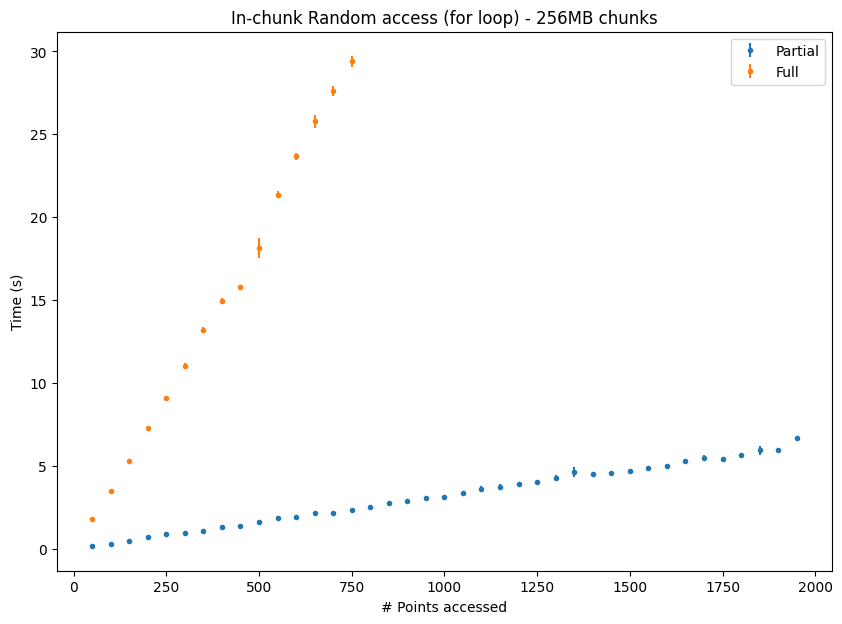

In [310]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.errorbar(index_lengths, exp1_partial_means, yerr=exp1_partial_stds, fmt='.', label="Partial")
plt.errorbar(index_lengths[0:15], exp1_normal_means, yerr=exp1_normal_stds, fmt='.', label="Full")

plt.xlabel("# Points accessed")
plt.ylabel("Time (s)")
plt.title("In-chunk Random access (for loop) - 256MB chunks")

plt.legend()
plt.show()

## Same experiment, multiple chunk sizes

#### Access 64KB - 1GB on arrays chunked in various sizes

In [3]:
# Load 4MB chunks afresh

import numpy as np
import zarr

# Define data location
fsstore = zarr.storage.FSStore("./fsstore4MB")
# Load data - partial_decompress and full decompress
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
chunk_shape = (2048, 512)

In [20]:
load_disk_normally.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [5]:
load_disk_normally[0, 0:10]

array([57071, 13148, 30458, 42086, 16973, 17592, 37421, 40209, 46026,
        6304], dtype=int32)

In [18]:
access_sizes = [2**i for i in range(12, 21)] # 64 KB - 4MB sequential access. Remember int32-4bytes
access_sizes

[4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]

In [19]:
[int(a / chunk_shape[1]) for a in access_sizes]

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [15]:
decomp_sequential_access = []

for acc_size in access_sizes:
    _ = %timeit -o load_partial_decomp[0:int(acc_size / chunk_shape[1]), 0:512]
    decomp_sequential_access.append(_)

711 µs ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
739 µs ± 79.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
629 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
741 µs ± 97.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
725 µs ± 54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
702 µs ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
678 µs ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
729 µs ± 37.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
788 µs ± 49.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.25 ms ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.54 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.01 ms ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.85 ms ± 65.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
no_decomp_sequential_access = []

for acc_size in access_sizes:
    _ = %timeit -o load_disk_normally[0:int(acc_size / chunk_shape[1]), 0:512]
    no_decomp_sequential_access.append(_)

1.01 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.01 ms ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.02 ms ± 37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.03 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.01 ms ± 9.62 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.14 ms ± 86.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.11 ms ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.17 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.13 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.14 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.2 ms ± 74.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.19 ms ± 97.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.95 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
# Pickle above

import pickle

partial_sequential_chunk_acc_file = open("partial_sequential_4MBchunk_acc.pickle", 'wb')
normal_sequential_chunk_acc_file = open("normal_sequential_4MBchunk_acc.pickle", "wb")

pickle.dump(decomp_sequential_access, partial_sequential_chunk_acc_file)
pickle.dump(no_decomp_sequential_access, normal_sequential_chunk_acc_file)

partial_sequential_chunk_acc_file.close()
normal_sequential_chunk_acc_file.close()

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.errorbar(index_lengths, exp1_partial_means, yerr=exp1_partial_stds, fmt='.', label="Partial")
plt.errorbar(index_lengths[0:15], exp1_normal_means, yerr=exp1_normal_stds, fmt='.', label="Full")

plt.xlabel("# Points accessed")
plt.ylabel("Time (s)")
plt.title("In-chunk Random access (for loop) - 256MB chunks")

plt.legend()
plt.show()

NameError: name 'index_lengths' is not defined

<Figure size 1000x700 with 0 Axes>

### Experiment 2 Plotting - Stabbing across-chunk access

In [265]:
exp2_partial_means = [x.average for x in stabbing_partial]
exp2_partial_stds = [x.stdev for x in stabbing_partial]

exp2_normal_means = [x.average for x in stabbing_normal]
exp2_normal_stds = [x.stdev for x in stabbing_normal]

# Can't label x-axis with tuples

In [286]:
exp2_points_accessed = []

for i in range(len(x_dirs)):
    exp2_points_accessed.append(2*x_dirs[i] + 2*y_dirs[i])

exp2_points_accessed

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 1536, 2560]

In [314]:
stabbing_partial

[<TimeitResult : 3.06 s ± 139 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 4.15 s ± 189 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 6.53 s ± 236 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 11.1 s ± 197 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 19.7 s ± 240 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 37.6 s ± 340 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 1min 13s ± 79 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 2min 25s ± 927 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3min 14s ± 762 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 6min 24s ± 1.68 s per loop (mean ± std. dev. of 3 runs, 1 loop each)>]

In [264]:
stabbing_normal

[<TimeitResult : 2.96 s ± 4.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3.15 s ± 278 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 2.96 s ± 13.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 2.97 s ± 20.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 2.98 s ± 24.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3.29 s ± 401 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3.2 s ± 19.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3.23 s ± 18.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3.28 s ± 13.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3.61 s ± 19.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>,
 <TimeitResult : 3.7 s ± 11.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>]

In [318]:
exp2_points_accessed

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 1536, 2560]

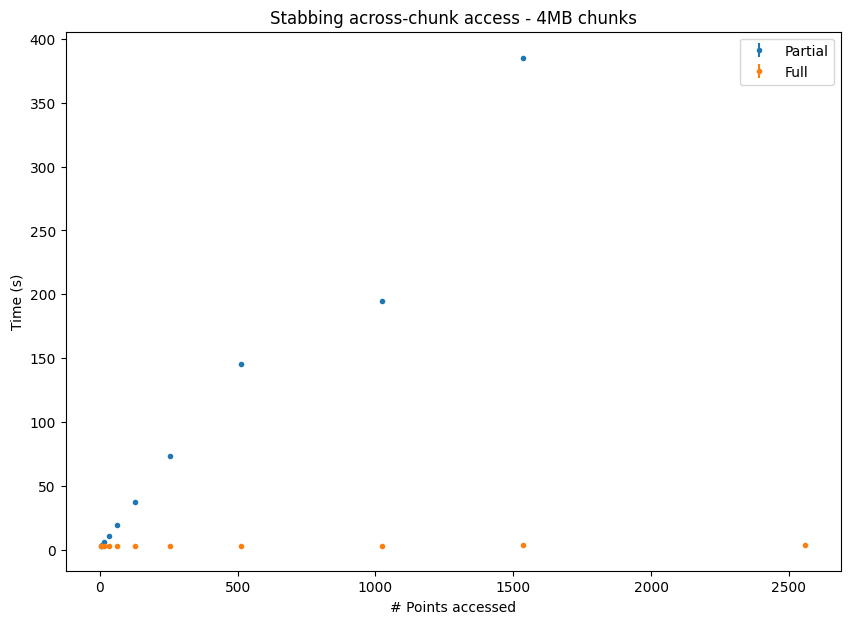

In [309]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.errorbar(exp2_points_accessed[0:10], exp2_partial_means, yerr=exp2_partial_stds, fmt='.', label="Partial")
plt.errorbar(exp2_points_accessed, exp2_normal_means, yerr=exp2_normal_stds, fmt='.', label="Full")

plt.xlabel("# Points accessed")
plt.ylabel("Time (s)")
plt.title("Stabbing across-chunk access - 4MB chunks")

plt.legend()
plt.show()

### Experiment 3 Plotting - Large Square In-Chunk access

In [298]:
exp3_partial_means = [x.average for x in decomp_sequential_access]
exp3_partial_stds = [x.stdev for x in decomp_sequential_access]

exp3_normal_means = [x.average for x in no_decomp_sequential_access]
exp3_normal_stds = [x.stdev for x in no_decomp_sequential_access]

In [312]:
decomp_sequential_access

[<TimeitResult : 7.4 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 7.51 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 7.78 ms ± 531 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 8.51 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 8.1 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>,
 <TimeitResult : 13.1 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 10.9 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 10.7 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 11.1 ms ± 688 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 14.8 ms ± 655 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 25.4 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>,
 <TimeitRes

In [313]:
no_decomp_sequential_access

[<TimeitResult : 9.17 ms ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 9.21 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 10.4 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 9.28 ms ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 10.3 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 12 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 9.53 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 9.82 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 10.4 ms ± 80.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 11.3 ms ± 82.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <TimeitResult : 11.4 ms ± 75.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 <T

In [317]:
access_sizes

[4096,
 8192,
 16384,
 32768,
 65536,
 131072,
 262144,
 524288,
 1048576,
 2097152,
 4194304,
 8388608,
 16777216,
 33554432,
 67108864]

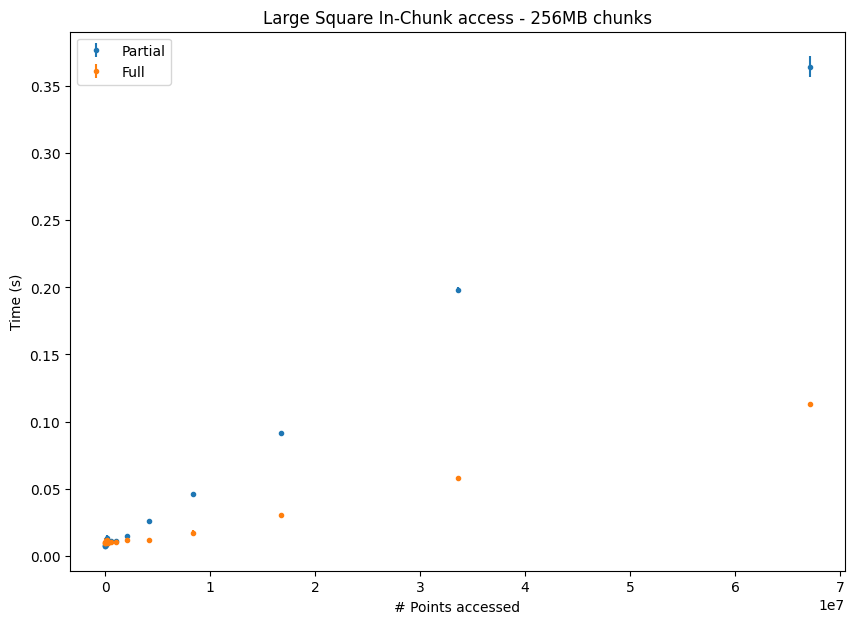

In [311]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.errorbar(access_sizes, exp3_partial_means, yerr=exp3_partial_stds, fmt='.', label="Partial")
plt.errorbar(access_sizes, exp3_normal_means, yerr=exp3_normal_stds, fmt='.', label="Full")

plt.xlabel("# Points accessed")
plt.ylabel("Time (s)")
plt.title("Large Square In-Chunk access - 256MB chunks")

plt.legend()
plt.show()

## Experiment 4 - Lagrangian 3D point access

In [1]:
import numpy as np

numpy_3d_arr = np.random.randint(low=0, high=1000, size=(16384, 4096, 80), dtype=np.int32) # 100 GB

In [2]:
np.info(numpy_3d_arr)

class:  ndarray
shape:  (16384, 4096, 80)
strides:  (1310720, 320, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x280000000
byteorder:  little
byteswap:  False
type: int32


In [7]:
# This fails bcs. it runs out of memory. Cannot define dtype manually
# numpy_3d_arr = np.random.random(size=(65536, 16384, 25), dtype=np.float)

In [4]:
import zarr

fsstore = zarr.storage.FSStore('./fsstore3D')
zarr_index_list = zarr.array(numpy_3d_arr, store=fsstore)#, chunks=chunk_shape)
zarr.save(fsstore, numpy_3d_arr)

In [5]:
del numpy_3d_arr

In [6]:
# Load 4MB chunks afresh

import numpy as np
import zarr

# Define data location
fsstore = zarr.storage.FSStore("./fsstore3D")
# Load data - partial_decompress and full decompress
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
# chunk_shape = (2048, 512)

In [7]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(16384, 4096, 80)"
Chunk shape,"(1024, 256, 5)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,21474836480 (20.0G)
No. bytes stored,8484694466 (7.9G)
Storage ratio,2.5
